# Questing Answering on SQuAD dataset

## Import libraries

In [94]:
import json
import pandas as pd
import os
import random
import pickle

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from typing import List, Callable, Dict
from nltk.stem import WordNetLemmatizer

from datetime import datetime
import keras
from keras import backend as K
from keras.layers import Concatenate, Lambda, LSTM, Reshape, Dense, Embedding, Average, Reshape, Flatten, Input, Add, Bidirectional, TimeDistributed, Softmax
from keras.models import Model 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import zipfile
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Layer

## Data pipeline

#### Load dataset

In [2]:
# Uncomment for google collab
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
folder = "SQUAD MATERIAL"
#folder = "drive/MyDrive/NLP_data/SQUAD MATERIAL"

In [ ]:
#dataset_folder = "drive/MyDrive/NLP_data/dataset/"
dataset_folder = './dataset'

In [4]:
def load_json(filename="training_set.json", folder=folder):    
    dataset_folder = os.path.join(os.getcwd(), folder)
    dataset_path = os.path.join(dataset_folder, filename)
    with open(dataset_path) as f:
        raw_json = json.load(f)

    return raw_json['data']

In [5]:
#data = load_json()

#### Split dataset into train, val and test sets.
Splitting on title, so that all answers and questions in one title are in the same dataset

In [6]:
def split_dataset(data):
    random.shuffle(data)
    length_of_dataset = len(data)
    train_split = round(0.8*length_of_dataset)
    val_split = train_split + round(0.1*length_of_dataset)
    train_data = data[:train_split]
    val_data = data[train_split:val_split]
    test_data = data[val_split:]
    return train_data, val_data, test_data

In [7]:
#train_data, val_data, test_data = split_dataset(data)

In [ ]:
def save_splits():
    with open(f"{dataset_folder}train.json", 'w') as f:
        d = {'data': train_data}
        json.dump(d,f)
    
    with open(f"{dataset_folder}val.json", 'w') as f:
        d = {'data': val_data}
        json.dump(d,f)

    with open(f"{dataset_folder}test.json", 'w') as f:
        d = {'data': test_data}
        json.dump(d,f)

In [ ]:
def get_data():
    train_data = load_json(filename="train.json", folder=dataset_folder)
    val_data = load_json(filename="val.json", folder=dataset_folder)    
    test_data = load_json(filename="test.json", folder=dataset_folder) 
    return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = get_data()

#### Create dataframe

In [8]:
def find_word_index(char_idx, context):
    return context[0:char_idx].count(' ')

In [9]:
def create_dataframe(data):
    contexts = []
    questions = []
    answers_text = []
    answers_start = []
    answers_end = []
    question_ids = []
    answers_word_start = []
    answers_word_end = []
    for i in range(len(data)):
        paragraphs = data[i]['paragraphs']
        for sub_para in paragraphs:
            for q_a in sub_para['qas']:
                questions.append(q_a['question'])
                q_a_answer_starts = []
                q_a_answer_ends = []
                q_a_answers = []
                q_a_ans_word_idx_start = []
                q_a_ans_word_idx_end = []

                for answer in q_a['answers']:
                    answer_end = answer['answer_start'] + len(answer['text'])
                    q_a_answer_starts.append(answer['answer_start'])
                    q_a_answer_ends.append(answer_end)
                    q_a_answers.append(answer['text'])
                    q_a_ans_word_idx_start.append(find_word_index(answer['answer_start'], sub_para['context']))
                    q_a_ans_word_idx_end.append(find_word_index(answer_end, sub_para['context']))
                    
                answers_start.append(q_a_answer_starts)
                answers_end.append(q_a_answer_ends)
                answers_word_start.append(q_a_ans_word_idx_start)                
                answers_word_end.append(q_a_ans_word_idx_end)
                answers_text.append(q_a_answers)
                question_ids.append(q_a['id'])
                contexts.append(sub_para['context'])   
    df = pd.DataFrame({"questionID":question_ids, "context":contexts, "question": questions, "answer_start": answers_start, "answer_word_start": answers_word_start, "answer_end": answers_end, "answer_word_end": answers_word_end, "answer_text": answers_text})
    return df

In [10]:
train_df = create_dataframe(train_data)
val_df = create_dataframe(val_data)
test_df = create_dataframe(test_data)

In [11]:
train_df

,questionID,context,question,answer_start,answer_word_start,answer_end,answer_word_end,answer_text
0,5732977f0342181400a20283,A police force is a constituted body of person...,What does the state want a police force to do?,[74],[14],[133],[22],"[enforce the law, protect property, and limit ..."
1,5732977f0342181400a20284,A police force is a constituted body of person...,What are gendarmerie?,[567],[90],[609],[95],[military units charged with civil policing]
2,5732977f0342181400a20285,A police force is a constituted body of person...,What are police usually separate from?,[445],[73],[540],[86],[military or other organizations involved in t...
3,573297e560535514009162f8,"Law enforcement, however, constitutes only par...",How are police usually paid?,[535],[83],[548],[84],[through taxes]
4,573297e560535514009162fa,"Law enforcement, however, constitutes only par...",When were police used to protect the class sys...,[237],[35],[271],[40],[late 18th and early 19th centuries]
...,...,...,...,...,...,...,...,...
70838,57279954708984140094e1e7,"Instead of being defined by ""non"" words, some ...",What type of language has it been suggested th...,[28],[5],[39],[6],"[""non"" words]"
70839,57279954708984140094e1e8,"Instead of being defined by ""non"" words, some ...",What type of language are organizations being ...,[75],[11],[109],[13],"[new, positive-sounding terminology]"
70840,57279954708984140094e1e9,"Instead of being defined by ""non"" words, some ...",What is a new term for NPOs that has started t...,[144],[20],[170],[22],[civil society organization]
70841,57279954708984140094e1ea,"Instead of being defined by ""non"" words, some ...",What is a term being used for organizations th...,[295],[45],[322],[47],[citizen sector organization]


### Clean and transform data

#### Clean text

In [12]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))



def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()    

def lemmatize_words(text: str ) -> str:
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

PREPROCESSING_PIPELINE = [
                          lower,
                          strip_text
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    if type(text) == list:
        new_row = [reduce(lambda txt, f: f(txt), filter_methods, x) for x in text]
    else:
        new_row = reduce(lambda txt, f: f(txt), filter_methods, text)
    return new_row

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreastettejessen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
to_be_cleaned = ["context", "question", "answer_text"]
for key in to_be_cleaned:
    train_df[key] = train_df[key].apply(lambda txt: text_prepare(txt))
    val_df[key] = val_df[key].apply(lambda txt: text_prepare(txt))
    test_df[key] = test_df[key].apply(lambda txt: text_prepare(txt))
    

#### Make tokenixer

###### THINGS TO THINK ABOUT
- Now its the padding is exstream! The questions has to be 3706 caracters long!
- We are only fitting on text the train context and questions. Should this also be done for val/train?
- Preprocessing is only lowering the words. Should we do more, like removing stopwords? In that case we need to consider the answer_start index. This has to be corrected after removal of carachters
- OOV are handeled with index 1 and will all have weights 0 in the beginning. is this correct?


In [14]:
# The tokenizer will have an index 1 for OOV words. A lot of words in test and val will be 1.
tokenizer = Tokenizer(oov_token=1)

tokenizer.fit_on_texts(train_df["context"])
tokenizer.fit_on_texts(train_df["question"])

In [15]:
# Find max sentence lenght for the context
MAX_SEQ_LEN = np.max([len(row.split(' ')) for row in train_df["context"]])

In [16]:
MAX_SEQ_LEN

562

In [17]:
def textToTensor(tokenizer, max_len, text):
    '''
        Converts text to tensors by converting the words into the correct indexes. 
        Then padds the tensors with 0 vlaues
    '''
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences=seq, maxlen=max_len, padding='post')
    return padded

In [18]:
context_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["context"])
question_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["question"])

context_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["context"])
question_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["question"])

context_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["context"])
question_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["question"])

In [19]:
# Takes only the first answer: simplification
# Can do this because we know there are only one answer for each question in our dataset
# Might need to change this
index_start_train = to_categorical(np.array(train_df["answer_word_start"].str[0]), num_classes=MAX_SEQ_LEN)
index_end_train = to_categorical(np.array(train_df["answer_word_end"].str[0]), num_classes=MAX_SEQ_LEN)

index_start_val = to_categorical(np.array(val_df["answer_word_start"].str[0]), num_classes=MAX_SEQ_LEN)
index_end_val = to_categorical(np.array(val_df["answer_word_end"].str[0]), num_classes=MAX_SEQ_LEN)

index_start_test = np.array(train_df["answer_word_start"].str[0])
index_end_test = np.array(train_df["answer_word_end"].str[0])

In [20]:
# Find size of vocabulary
VOCABULARY_SIZE = len(tokenizer.word_index) + 1

#### Applying glove

In [21]:
import gensim 
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model
    
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix


In [22]:
embedding_dimension = 50

embedding_model = load_embedding_model(embedding_dimension)
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)
embedding_matrix.shape

(81463, 50)

## Create model

### Define layers

##### Similarity matrix

In [23]:
class Similarity(Layer):

    def __init__(self, **kwargs):
        super(Similarity, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = input_shape[0][-1]*3
        self.kernel = self.add_weight(name='similarity_weight',
                                        shape=(shape, 1),
                                        initializer='uniform',
                                        trainable=True)
        super(Similarity, self).build(input_shape)
    def get_kernel(self):
        return self.kernel
    
    def call(self, inputs):
        A, B = inputs
        A_dim_repeat = K.concatenate([[1, 1], [A.shape[1]], [1]], 0)
        B_dim_repeat = K.concatenate([[1], [B.shape[1]], [1, 1]], 0)
        A_repeated = K.tile(K.expand_dims(A, axis=2), A_dim_repeat)
        B_repeated = K.tile(K.expand_dims(B, axis=1), B_dim_repeat)
        element_wise_multiplication = A_repeated * B_repeated
        concated = K.concatenate([A_repeated, B_repeated, element_wise_multiplication], axis=-1)
        dot= K.dot(concated, self.kernel)
        dot_product = K.squeeze(dot, axis=-1)
        return dot_product

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0][0]
        num_context_words = input_shape[0][1]
        num_query_words = input_shape[1][1]
        return (batch_size, num_context_words, num_query_words)

##### C2q

In [24]:
class Context2QuestionAttention(Layer):
    '''
    A = Take row-wise softmax of the similarity matrix
    Û = For every row in A (softmaxed similarity matrix), A_t:
        Multiply every element in A_t calculate the weighted sum of the question matrix. 
        (The weigths will be the elements in A_t)
    Input: Question matrix and similarity matrix
    '''
    def __init__(self, **kwargs):
        super(Context2QuestionAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(Context2QuestionAttention, self).build(input_shape)
    
    def call(self, inputs):
        question_encoding, similarity_matrix, mask = inputs

        masked_inp = tf.where(mask>0, similarity_matrix, tf.float64.min)
        # Take only soft max on non padded values
        softmax_similarity_matrix1 = Softmax(axis=-1)(masked_inp)
        softmax_similarity_matrix = tf.where(tf.math.is_nan(softmax_similarity_matrix1)!=True, softmax_similarity_matrix1, 0)

        question_encoding_expand = K.expand_dims(question_encoding, axis=1)
        softmax_similarity_matrix_expand = K.expand_dims(softmax_similarity_matrix, axis=-1)
        product = softmax_similarity_matrix_expand*question_encoding_expand
        summ = K.sum(product, axis=-2)
        
        return summ

    def compute_output_shape(self, input_shape):
        question_encoding_shape, _ = input_shape
        batch_size = question_encoding_shape[0]
        max_seq_len = question_encoding_shape[1]
        embedding_dim = question_encoding_shape[2]
        return (batch_size,max_seq_len, embedding_dim)

##### q2c

In [25]:
class Question2ContextAttention(Layer):
    '''
    Similraity matrix [max_seq_len, max_seq_len]
    Z = maximum across each row of the similarity matrix [max_seq_len, 1]
    b = softmax on Z to get attention distribution (max_seq_len, 1)
    ^h = Use b to take a weigthed sum of the contex matrix H (max_seq_len, 1)
    ^H = ^h dubplicated max_seq_len times (max_seq_len, max_seq_len)
    '''
    
    def __init__(self, **kwargs):
        super(Question2ContextAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(Question2ContextAttention, self).build(input_shape)
    
    def call(self, inputs):
        context_encoding, similarity_matrix, mask = inputs

        masked_inp = tf.where(mask>0, similarity_matrix, 0)
        max_sim_matrix = K.max(masked_inp, axis=-1) # K.max also squeezes
        # Take only softmax on non padded vlaues
        masked_inp2 = tf.where(max_sim_matrix!=0, max_sim_matrix, tf.float64.min)
        softmax_similarity_matrix = Softmax(axis=-1)(masked_inp2)
        softmax_similarity_matrix = tf.where(tf.math.is_nan(softmax_similarity_matrix)!=True, softmax_similarity_matrix, 0)

        softmax_similarity_matrix_expand = K.expand_dims(softmax_similarity_matrix, axis=-1)
        product = softmax_similarity_matrix_expand*context_encoding
        weighted_sum = K.sum(product, axis=-2)
        # Expand dimensions, so that vector can be repeated
        expanded_weighted_sum = K.expand_dims(weighted_sum, 1)
        # get max_seq_len
        max_seq_len = K.shape(context_encoding)[1]
        # repeat vector for max seq length to make matrix
        question2context_attention = K.tile(expanded_weighted_sum, [1, max_seq_len, 1])
        return question2context_attention

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0][0]
        num_context_words = input_shape[0][1]
        num_query_words = input_shape[1][1]
        return (batch_size, num_context_words, num_query_words)

##### Mega merge

In [26]:
class MegaMerge(Layer):
    '''
    For each word in max_seqence_length (T):
        cu = context elementwise multiply with Û (c2q) (2d, T)
        ch = context elementwise multiply with ^H (q2c) (2d, T)
        Stack for each column context, Û, cu, ch. [8*embedding_dim, 1]
    Output:
    mega_merge (8d, T)

    '''
    
    def __init__(self, **kwargs):
        super(MegaMerge, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(MegaMerge, self).build(input_shape)
    
    def call(self, inputs):
        context_encoding, context2question_attention, question2context_attention = inputs

        element_wise_multiply1 = context_encoding * context2question_attention
        element_wise_multiply2 = context_encoding * question2context_attention

        mega_merge = K.concatenate([context_encoding, context2question_attention, element_wise_multiply1, element_wise_multiply2], axis=-1)
        return mega_merge

    def compute_output_shape(self, input_shape):
        context_encoding_shape , _, _ = input_shape
        batch_size = context_encoding_shape[0]
        max_seq_len = context_encoding_shape[1]
        embedding_dim2 = context_encoding_shape[2]
        return (batch_size, max_seq_len, embedding_dim2*4)

##### Output layer start

In [27]:
class StartOutput(Layer):
    '''
    1. super merge = Concatenate first hidden_layer(T,2d) with Mega merge(T,8d)
    Make trainable weigths (10d, 1)
    2. dotted = Dotproduct with trainable weigths and super merge (T,1)
    3. out = Softmax the dotted vector (T,1)
    Output:
    out (T,1)

    '''
    
    def __init__(self, **kwargs):
        super(StartOutput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = input_shape[0][-1]*5 # want 10*embedding dimention
        self.kernel = self.add_weight(name='startOutput_weight',
                                        shape=(shape, 1),
                                        initializer='uniform',
                                        trainable=True)
        super(StartOutput, self).build(input_shape)
    
    def call(self, inputs):
        hidden_layer, mega_merge, mask = inputs

        super_merge = K.concatenate([mega_merge, hidden_layer])
        dotted = K.squeeze(K.dot(super_merge, self.kernel), axis=-1)
        masked_inp = tf.where(mask!=False, dotted, tf.float64.min)
        # OBS try without mask stuff. With mask change dotted to be masked_inp
        soft_max_dotted = Softmax(axis=-1)(masked_inp)
        return soft_max_dotted

    def compute_output_shape(self, input_shape):
        hidden_layer , _, _ = input_shape
        batch_size = hidden_layer[0]
        max_seq_len = hidden_layer[1]
        return (batch_size, max_seq_len, 1)

In [28]:
class EndOutput(Layer):
    '''
    1. super merge = Concatenate second hidden layer with Mega merge
    Make trainable weigths (10d, 1)
    2. dotted = Dotproduct with trainable weigths and super merge (T,1)
    3. out = Softmax the dotted vector (T,1)
    Output:
    out (T,1)

    '''
    
    def __init__(self, **kwargs):
        super(EndOutput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = input_shape[0][-1]*5 # want 10*embedding dimention
        self.kernel = self.add_weight(name='endOutput_weight',
                                        shape=(shape, 1),
                                        initializer='uniform',
                                        trainable=True)
        super(EndOutput, self).build(input_shape)
    
    def call(self, inputs):
        hidden_layer, mega_merge, mask = inputs
        super_merge = K.concatenate([mega_merge, hidden_layer])

        dotted = K.squeeze(K.dot(super_merge, self.kernel), axis=-1)
        masked_inp = tf.where(mask!=False, dotted, tf.float64.min)
        # OBS try without mask stuff. With mask change dotted to be masked_inp
        soft_max_dotted = Softmax(axis=-1)(masked_inp)
        return soft_max_dotted

    def compute_output_shape(self, input_shape):
        hidden_layer , _, _ = input_shape
        batch_size = hidden_layer[0]
        max_seq_len = hidden_layer[1]
        return (batch_size, max_seq_len, 1)

### Create model

In [29]:
def create_model(max_tokens, vocab_size, embedding_dimension):
    '''
        Creates keras model for classification.
        Inputs: 
            max_tokens (int): Max length of a text sequence
            vocab_size (int): Size of the vocabulary
            embedding_dimension (int): The dimension of the embedding vectors
    '''   

    #-------------------------- Input layer ------------------------------------------------------------
    question_input = Input(shape=(max_tokens, ))
    context_input = Input(shape=(max_tokens, ))
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Word embedding ------------------------------------------------------------
    question_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_question', trainable = False, mask_zero = True)(question_input)
    context_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_context', trainable = False, mask_zero = True)(context_input)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Encoding/sentence embedding -------------------------------------------------------
    # Encode token sequences with bi-directional LSTM and concatenate the series of hidden vectors (done by default)
    question_encoding = Bidirectional(LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims'))(question_embedding)
    context_encoding = Bidirectional(LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence'))(context_embedding)
    #-----------------------------------------------------------------------------------------------------
    
    # OBS addef the mask to remove padding
    emb = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_context', trainable = False, mask_zero = True)
    
    mask_question = emb.compute_mask(question_input)
    mask_context = emb.compute_mask(context_input)

    mask_question_int = tf.cast(mask_question, tf.float32)
    mask_context_int = tf.cast(mask_context, tf.float32)

    mask_question_expand = tf.expand_dims(mask_question_int, 1)
    mask_context_expand = tf.expand_dims(mask_context_int, 2)

    combined_mask = mask_context_expand * mask_question_expand

    #-------------------------- Similarity ------------------------------------------------------------
    similarity_layer = Similarity()
    similarity_matrix = similarity_layer([question_encoding, context_encoding])

    # Replacing values in similarity matrix where context is padding 
    masked_similarity_matrix = tf.where(combined_mask>0, similarity_matrix, 0)
    #-------------------------- Attention ------------------------------------------------------------
    c2q = Context2QuestionAttention()
    context2question_attention = c2q([question_encoding, masked_similarity_matrix, combined_mask])

    q2c = Question2ContextAttention()
    question2context_attention = q2c([context_encoding, masked_similarity_matrix, combined_mask])
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Megamerge --------------------------------------------------------------
    mm = MegaMerge()
    mega_merge = mm([context_encoding, context2question_attention, question2context_attention])

    #-------------------------- Model layer --------------------------------------------------------------
    hidden_layer = Bidirectional(LSTM(embedding_dimension, return_sequences=True))(mega_merge)
    hidden_layer2 = Bidirectional(LSTM(embedding_dimension, return_sequences=True))(hidden_layer)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Output layer -------------------------------------------------------------
    start_out_model = StartOutput(name="start_output")
    start_probabilities = start_out_model([hidden_layer, mega_merge, mask_context])

    end_out_model = EndOutput(name="end_output")
    end_probabilities = end_out_model([hidden_layer2, mega_merge, mask_context])

    return Model(inputs=[question_input, context_input], outputs=[start_probabilities, end_probabilities])


In [30]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, 50)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 562)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 562)]        0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 562)         0           ['input_2[0][0]']                
 a)                                                                                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 562)         0           ['input_1[0][0]']            

## Train

In [31]:
_EPSILON = 1e-7
def categorical_cross_entropy_loss(target, output):
    output /= tf.reduce_sum(output, -1, True)
    # manual computation of crossentropy
    epsilon = K.constant(_EPSILON, output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon, 1. - epsilon)
    return - tf.reduce_sum(target * tf.math.log(output), -1)

In [32]:
losses = {"start_output": categorical_cross_entropy_loss, "end_output": categorical_cross_entropy_loss}

lossWeights = {"start_output": 1.0, "end_output": 1.0}

In [33]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(loss=losses,
              loss_weights=lossWeights, 
              optimizer=adam,
              metrics=['categorical_accuracy'])
history = model.fit(x=[question_train, context_train], y= {"start_output": index_start_train, "end_output": index_end_train}, batch_size=8, epochs=2, validation_data=([question_val, context_val], {"start_output": index_start_val, "end_output": index_end_val}))

Epoch 1/2
 101/8856 [..............................] - ETA: 68:40:14 - loss: 9.2665 - start_output_loss: 4.6652 - end_output_loss: 4.6013 - start_output_categorical_accuracy: 0.0371 - end_output_categorical_accuracy: 0.0384

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Save model

In [95]:
def save_history(dir, model_name, history):
    print(type(history))
    path = f'{dir}/{model_name}/history'
    print(f'Saving history to {path}')
    with open(path, 'wb') as file:
     pickle.dump(history.history, file)

def save_tokenizer(dir, model_name, tokenizer):
    path = f'{dir}/{model_name}/tokenizer.txt'
    print(f'Saving tokenizer to {path}')
    with open(path, 'w') as file:
     file.write(json.dumps(tokenizer.word_index))

def save_max_seq_len(dir, model_name, MAX_SEQ_LEN):
    path = f'{dir}/{model_name}/MAX_SEQ_LEN.txt'
    print(f'Saving max seq len to {path}')
    with open(path, 'w') as file:
     file.write(json.dumps(int(MAX_SEQ_LEN)))

def save_model(model, tokenizer, MAX_SEQ_LEN, history, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_{dt_string}'
    path = f'{dir}/{model_name}/model/'
    model.save(path)
    save_tokenizer(dir, model_name, tokenizer)
    save_max_seq_len(dir, model_name, MAX_SEQ_LEN)
    save_history(dir, model_name, history)

In [ ]:
# model_dir = 'drive/MyDrive/NLP_data/model'
model_dir = 'models'

In [ ]:
save_model(model, tokenizer, MAX_SEQ_LEN, history, model_dir)

## Plot accuracy and loss

#### Load model history

In [96]:
model_dir = './models/model_30_12_2021_17_56_51'

In [97]:
def load_history(model_dir):
    with open(f'{model_dir}/history', 'rb') as f:
        history = pickle.load(f)
    return history

history = load_history(model_dir)

#### Plotting

In [100]:
def plot_accuracy(history):
    plt.plot(history['start_output_categorical_accuracy'])
    plt.plot(history['end_output_categorical_accuracy'])
    plt.plot(history['val_start_output_loss'])
    plt.plot(history['val_end_output_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_start_acc', 'train_end_acc' 'val_start_acc', 'val_end_acc'], loc="lower right")
    plt.show()
    
def plot_loss(history):
    plt.plot(history['start_output_loss'])
    plt.plot(history['end_output_loss'])
    plt.plot(history['val_start_output_loss'])
    plt.plot(history['val_end_output_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_start_output_loss', 'train_end_output_loss', 'val_start_output_loss', 'val_end_output_loss'], loc="lower right")
    plt.show()

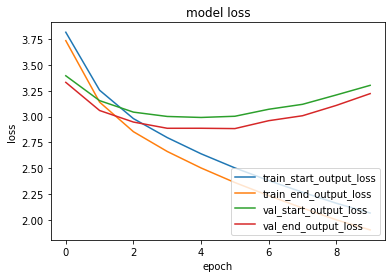

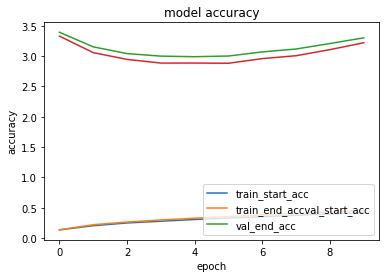

In [101]:
plot_loss(history)
plot_accuracy(history)